# 🛠 Transfer Learning in TensorFlow Part 3: Scaling-up Exercises

1. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?
2. Recreate the first model (the feature extraction model) with `mixed_precision` turned on.
    * Does it make the model train faster?
    * Does it effect the accuracy or performance of our model?
    * What's the advantages of using mixed_precision training?

In [ ]:
# Checking if connected to GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-71c70788-944d-779d-967e-930ca188210d)


## Feature extraction model on 10 epochs
Steps to train feature extraction model:
* Getting the data
* Preprocessing the data
* Building the model
* Training and evaluation of model

### Import helper functions

In [1]:
# Downloading the helper functions created in early notebooks
!wget https://raw.githubusercontent.com/kishan5111/Deep_Learning_Vault/main/notebooks/tensorflow_course/helper_functions.py

--2023-09-14 10:54:56--  https://raw.githubusercontent.com/kishan5111/Deep_Learning_Vault/main/notebooks/tensorflow_course/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10415 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.17K  --.-KB/s    in 0s      

2023-09-14 10:54:56 (103 MB/s) - ‘helper_functions.py’ saved [10415/10415]



In [2]:
# Import series of helper functions for the notebook
from helper_functions import walk_through_dir, unzip_data, plot_loss_curves, compare_historys, create_tensorboard_callback

### Downloading the data

101 Food Classes: working with less data

Our goal is to beat the original Food 101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food 101 dataset but has been preprocessed using the image_data_modification
notebook-  https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

--2023-09-14 10:55:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  17.9MB/s    in 87s     

2023-09-14 10:57:15 (17.8 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# let's walkthrough all the directories
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bread_pudding'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/onion_rings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chocolate_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/falafel'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beignets'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/deviled_eggs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gnocchi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_bisque'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/crab_cakes'.
There are 0 directories and 75 images in '1

In [4]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [5]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) #for prediction analysis



Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Train a model with transfer learning on 10% of 101 food classes

Here are steps we're going to take:
 * Create a ModelCheckpoint callback
 * Create a data augmentation layer to build data augmentation right into the model
 * Build a headless(no top layer) Functional EfficentNetB0 backboned-model(we'll create our own output layer)
 * Compile our model
 * Feature extract for 10 full passes(10 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [6]:
# create a checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"

check_point_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                          save_weights_only=True,
                                                          monitor="val_accuracy",
                                                          save_best_only=True)

In [7]:
# Create a data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [8]:
#  Creating data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name="data_augmentation_layer")

In [15]:
# Creating a model
# 1. Create topless base model and freeze the model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# 2. Create a input layer and passing through data aug layer
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs)

# 3. Pass through base model
x = base_model(x, training=False) #put the base model in inference mode so weights which need to stay frozen remains frozen

# 4. Average pooling layer and output layer
x = layers.GlobalAveragePooling2D(name="average_pooling_layer")(x)
outputs = layers.Dense(101, activation="softmax", name="output_layer")(x)

# Create a model
model_0 = tf.keras.Model(inputs, outputs)

In [17]:
# Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [18]:
# Fitting the model
%%time
history = model_0.fit(train_data_all_10_percent,
                      steps_per_epoch=len(train_data_all_10_percent),
                      epochs=10,
                      validation_data=test_data,
                      validation_steps=(0.15 * len(test_data)),
                      callbacks=[check_point_callback])

Epoch 1/10
237/237 [==============================] - 41s 140ms/step - loss: 3.3802 - accuracy: 0.2663 - val_loss: 2.5680 - val_accuracy: 0.4322
Epoch 2/10
237/237 [==============================] - 31s 130ms/step - loss: 2.2115 - accuracy: 0.4935 - val_loss: 2.1352 - val_accuracy: 0.4921
Epoch 3/10
237/237 [==============================] - 32s 136ms/step - loss: 1.8307 - accuracy: 0.5650 - val_loss: 1.9219 - val_accuracy: 0.5221
Epoch 4/10
237/237 [==============================] - 33s 135ms/step - loss: 1.6025 - accuracy: 0.6161 - val_loss: 1.8766 - val_accuracy: 0.5207
Epoch 5/10
237/237 [==============================] - 33s 137ms/step - loss: 1.4480 - accuracy: 0.6451 - val_loss: 1.8003 - val_accuracy: 0.5394
Epoch 6/10
237/237 [==============================] - 33s 138ms/step - loss: 1.3316 - accuracy: 0.6743 - val_loss: 1.7479 - val_accuracy: 0.5499
Epoch 7/10
237/237 [==============================] - 30s 125ms/step - loss: 1.2193 - accuracy: 0.6989 - val_loss: 1.7232 - val_ac

### Evaluating model

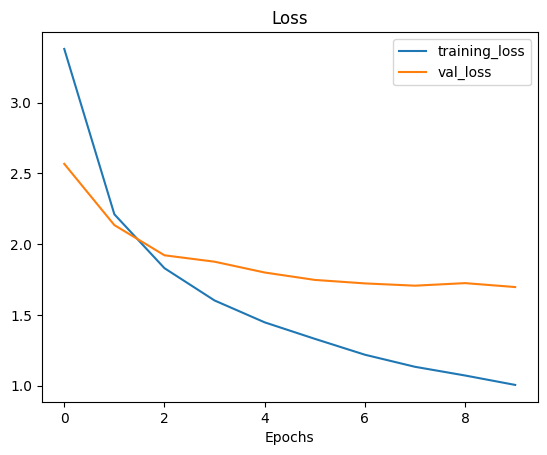

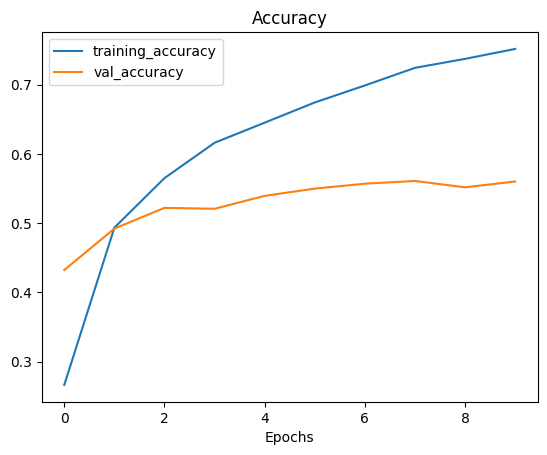

In [19]:
plot_loss_curves(history)

In [20]:
# Evaluate on full test data
results_feature_extractor= model_0.evaluate(test_data)

790/790 [==============================] - 66s 84ms/step - loss: 1.5067 - accuracy: 0.5973


In [21]:
model_0.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 3)     0         
 equential)                                                      
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 average_pooling_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                           

## Feature extraction on 5 epochs and fine tuning 5 epochs

### Building the model

In [22]:
# Creating a model
# 1. Create topless base model and freeze the model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# 2. Create a input layer and passing through data aug layer
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs)

# 3. Pass through base model
x = base_model(x, training=False) #put the base model in inference mode so weights which need to stay frozen remains frozen

# 4. Average pooling layer and output layer
x = layers.GlobalAveragePooling2D(name="average_pooling_layer")(x)
outputs = layers.Dense(101, activation="softmax", name="output_layer")(x)

# Create a model
model_1 = tf.keras.Model(inputs, outputs)

### Checkpoint callback

In [23]:
# create a checkpoint callback
checkpoint_path_feature_extractor = "101_classes_10_percent_data_model_checkpoint_feature_extractor"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_feature_extractor,
                                                          save_weights_only=True,
                                                          monitor="val_accuracy",
                                                          save_best_only=True)

### Compile and fit the model

In [24]:
model_1.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [25]:
%%time
history_feature_extractor_5_epoch = model_1.fit(train_data_all_10_percent,
                                                steps_per_epoch=len(train_data_all_10_percent),
                                                epochs=5,
                                                validation_data=test_data,
                                                validation_steps=(0.15 * len(test_data)),
                                                callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 39s 132ms/step - loss: 3.3737 - accuracy: 0.2752 - val_loss: 2.5484 - val_accuracy: 0.4315
Epoch 2/5
237/237 [==============================] - 30s 125ms/step - loss: 2.1925 - accuracy: 0.4995 - val_loss: 2.1454 - val_accuracy: 0.4800
Epoch 3/5
237/237 [==============================] - 32s 135ms/step - loss: 1.8241 - accuracy: 0.5659 - val_loss: 1.9326 - val_accuracy: 0.5202
Epoch 4/5
237/237 [==============================] - 30s 124ms/step - loss: 1.6101 - accuracy: 0.6107 - val_loss: 1.8616 - val_accuracy: 0.5252
Epoch 5/5
237/237 [==============================] - 31s 131ms/step - loss: 1.4553 - accuracy: 0.6466 - val_loss: 1.8112 - val_accuracy: 0.5281
CPU times: user 3min 38s, sys: 15.6 s, total: 3min 54s
Wall time: 3min 11s


### Evaluate the model

In [26]:
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 3)     0         
 equential)                                                      
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 average_pooling_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                           

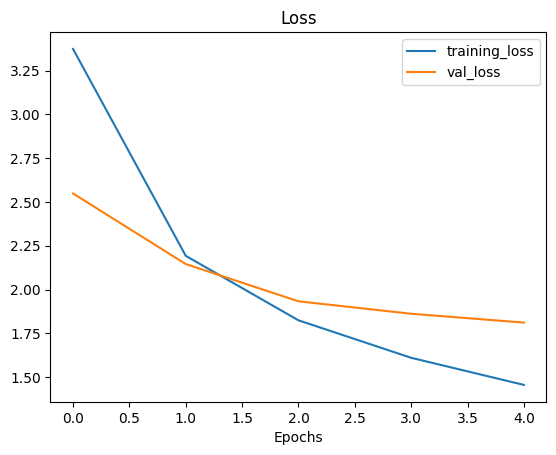

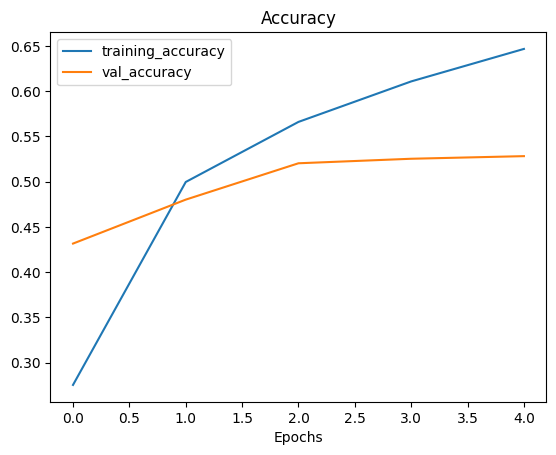

In [27]:
plot_loss_curves(history_feature_extractor_5_epoch)

In [28]:
# Evaluate on full test data
results_feature_extractor_5_epoch = model_1.evaluate(test_data)

790/790 [==============================] - 60s 76ms/step - loss: 1.5816 - accuracy: 0.5822


## Fine-tuning the model
Steps to fine-tune model:
* Take feature extractor model
* Unfreeze some layers
* Train and fit the model

### Making layers trainable

In [29]:
# unfreeze all of the layer of base model
base_model.trainable = True

# Refreeze every layer except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [30]:
# Check the trainable layers in base model
for i , layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

0 input_4 False
1 rescaling_6 False
2 normalization_3 False
3 rescaling_7 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [31]:
# Trainable layers in model
for layer in model_0.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation_layer True
efficientnetb0 False
average_pooling_layer True
output_layer True


### Compile and fit the model

In [32]:
model_1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(0.0001),
    metrics=["accuracy"]
)

In [33]:
initial_epoch = 5
fine_tune_epoch = initial_epoch + 5
history_fine_tune = model_1.fit(train_data_all_10_percent,
                                steps_per_epoch=len(train_data_all_10_percent),
                                validation_data=test_data,
                                validation_steps=(0.15 * len(test_data)),
                                epochs = fine_tune_epoch,
                                initial_epoch = history_feature_extractor_5_epoch.epoch[-1])

Epoch 5/10
237/237 [==============================] - 42s 139ms/step - loss: 1.2142 - accuracy: 0.6834 - val_loss: 1.7403 - val_accuracy: 0.5444
Epoch 6/10
237/237 [==============================] - 29s 122ms/step - loss: 1.0887 - accuracy: 0.7098 - val_loss: 1.7136 - val_accuracy: 0.5544
Epoch 7/10
237/237 [==============================] - 30s 125ms/step - loss: 1.0149 - accuracy: 0.7296 - val_loss: 1.7564 - val_accuracy: 0.5470
Epoch 8/10
237/237 [==============================] - 29s 123ms/step - loss: 0.9521 - accuracy: 0.7471 - val_loss: 1.7128 - val_accuracy: 0.5580
Epoch 9/10
237/237 [==============================] - 31s 127ms/step - loss: 0.8855 - accuracy: 0.7642 - val_loss: 1.6848 - val_accuracy: 0.5604
Epoch 10/10
237/237 [==============================] - 30s 125ms/step - loss: 0.8179 - accuracy: 0.7835 - val_loss: 1.7104 - val_accuracy: 0.5593


In [34]:
fine_tuned_result = model_1.evaluate(test_data)

790/790 [==============================] - 58s 73ms/step - loss: 1.5104 - accuracy: 0.5992


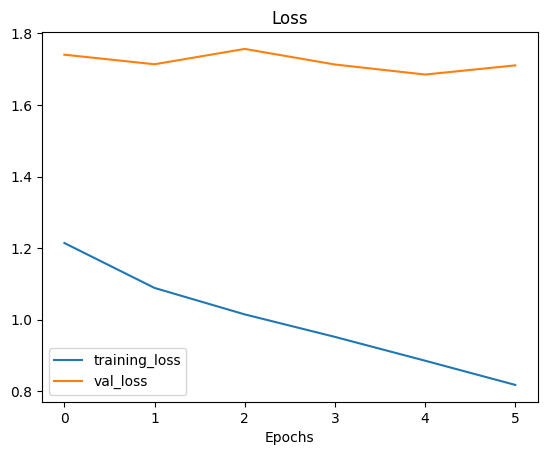

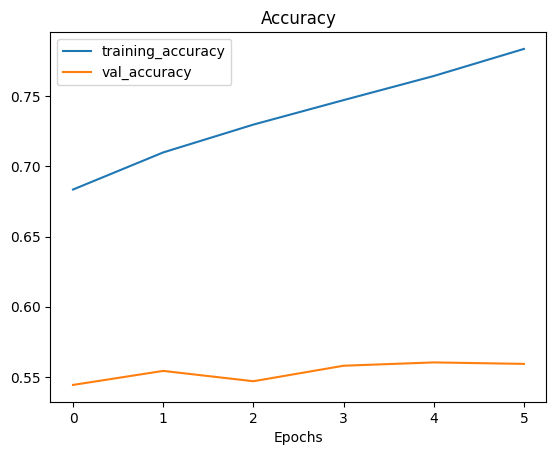

In [35]:
plot_loss_curves(history_fine_tune)

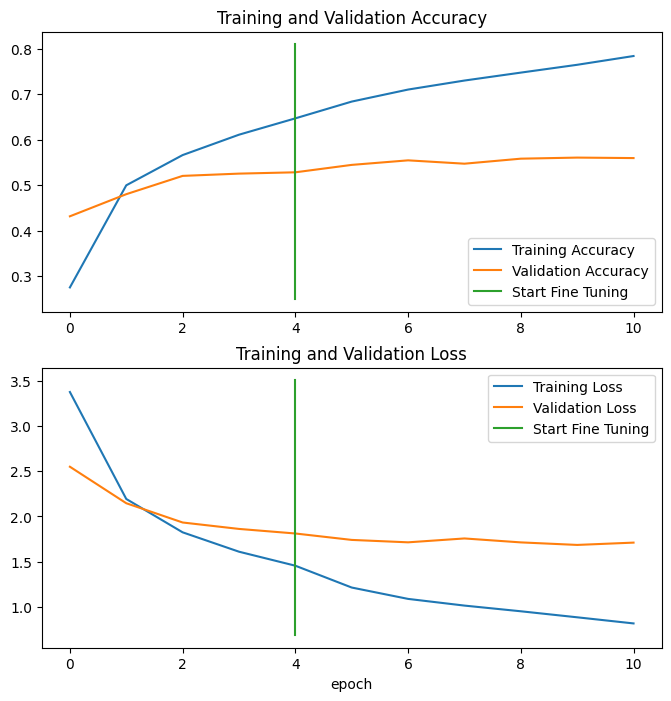

In [36]:
# compare the historys
compare_historys(original_history=history_feature_extractor_5_epoch, new_history=history_fine_tune,initial_epochs=5)

## Evaluate all models

In [37]:
import pandas as pd

data = {
    "feature_extractor_10_epoch_model":[results_feature_extractor[0], results_feature_extractor[1]],
    "feature_extractor_5_epoch_model": [results_feature_extractor_5_epoch[0], results_feature_extractor_5_epoch[1]],
    "fine_tuned_5_epoch_model": [fine_tuned_result[0], fine_tuned_result[1]]
}
df = pd.DataFrame(data, index=["loss", "accuracy"])

In [38]:
df

,feature_extractor_10_epoch_model,feature_extractor_5_epoch_model,fine_tuned_5_epoch_model
loss,1.506748,1.581583,1.510417
accuracy,0.597347,0.582218,0.599168


### Plotting models results

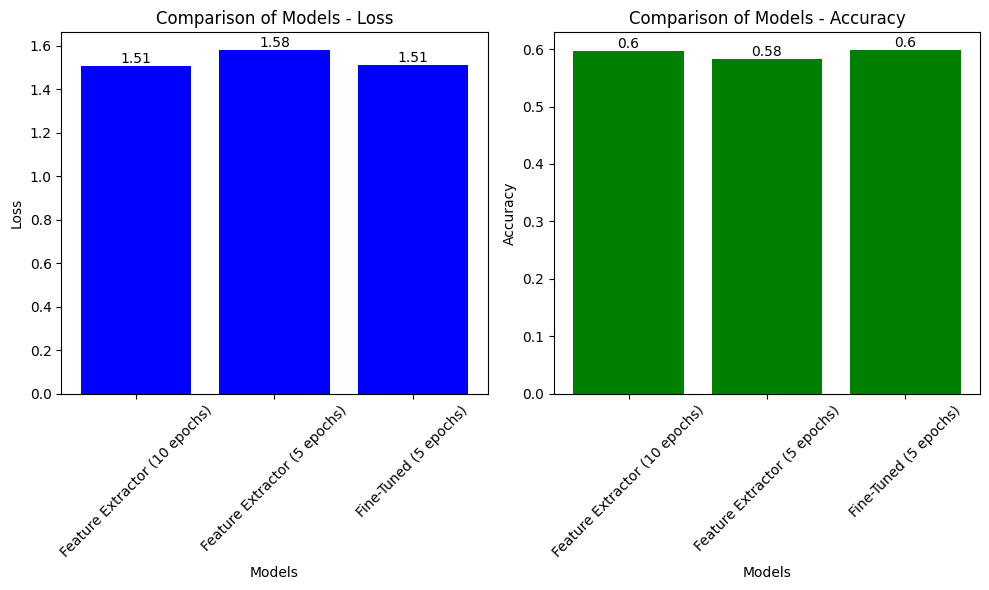

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ["Feature Extractor (10 epochs)", "Feature Extractor (5 epochs)", "Fine-Tuned (5 epochs)"]
loss_values = [results_feature_extractor[0], results_feature_extractor_5_epoch[0], fine_tuned_result[0]]
accuracy_values = [results_feature_extractor[1], results_feature_extractor_5_epoch[1], fine_tuned_result[1]]

# Plotting
plt.figure(figsize=(10, 6))

# Loss comparison plot
plt.subplot(1, 2, 1)
bars_loss = plt.bar(models, loss_values, color='b')
plt.title("Comparison of Models - Loss")
plt.xlabel("Models")
plt.ylabel("Loss")
plt.xticks(rotation=45)  # Rotate the tick labels by 45 degrees

# Add values on top of bars for loss
for bar_loss in bars_loss:
    height = bar_loss.get_height()
    plt.text(bar_loss.get_x() + bar_loss.get_width() / 2, height, round(height, 2), ha='center', va='bottom')

# Accuracy comparison plot
plt.subplot(1, 2, 2)
bars_accuracy = plt.bar(models, accuracy_values, color='g')
plt.title("Comparison of Models - Accuracy")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)  # Rotate the tick labels by 45 degrees

# Add values on top of bars for accuracy
for bar_accuracy in bars_accuracy:
    height = bar_accuracy.get_height()
    plt.text(bar_accuracy.get_x() + bar_accuracy.get_width() / 2, height, round(height, 2), ha='center', va='bottom')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


## Recreating feature extraction model with mixed_precision turned on
* Does it make the model train faster?
* Does it effect the accuracy or performance of our model?
* What's the advantages of using mixed_precision training?

### Building and training a model  

In [40]:
# Creating a model
# 1. Create topless base model and freeze the model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# 2. Create a input layer and passing through data aug layer
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs)

# 3. Pass through base model
x = base_model(x, training=False) #put the base model in inference mode so weights which need to stay frozen remains frozen

# 4. Average pooling layer and output layer
x = layers.GlobalAveragePooling2D(name="average_pooling_layer")(x)
outputs = layers.Dense(101, activation="softmax", name="output_layer")(x)

# Create a model
model_2 = tf.keras.Model(inputs, outputs)

Turning ON mixed precision

In [41]:
import tensorflow as tf

# Enable mixed precision policy
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Create a loss scale optimizer
optimizer = tf.keras.optimizers.Adam()
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

In [42]:
model_2.compile(optimizer=optimizer,
                loss="categorical_crossentropy",
                metrics=["accuracy"])

In [43]:
%%time
history_mixed_precision_model = model_2.fit(train_data_all_10_percent,
                                            steps_per_epoch=len(train_data_all_10_percent),
                                            validation_steps=(0.15 * len(test_data)),
                                            validation_data=test_data,
                                            epochs=10
                                            )

Epoch 1/10
237/237 [==============================] - 40s 134ms/step - loss: 3.3893 - accuracy: 0.2696 - val_loss: 2.5101 - val_accuracy: 0.4653
Epoch 2/10
237/237 [==============================] - 29s 120ms/step - loss: 2.2024 - accuracy: 0.5026 - val_loss: 2.0854 - val_accuracy: 0.5074
Epoch 3/10
237/237 [==============================] - 29s 120ms/step - loss: 1.8192 - accuracy: 0.5677 - val_loss: 1.9167 - val_accuracy: 0.5341
Epoch 4/10
237/237 [==============================] - 31s 130ms/step - loss: 1.6005 - accuracy: 0.6164 - val_loss: 1.8001 - val_accuracy: 0.5507
Epoch 5/10
237/237 [==============================] - 29s 119ms/step - loss: 1.4482 - accuracy: 0.6446 - val_loss: 1.7756 - val_accuracy: 0.5512
Epoch 6/10
237/237 [==============================] - 32s 133ms/step - loss: 1.3252 - accuracy: 0.6698 - val_loss: 1.7444 - val_accuracy: 0.5528
Epoch 7/10
237/237 [==============================] - 28s 117ms/step - loss: 1.2322 - accuracy: 0.6970 - val_loss: 1.7266 - val_ac

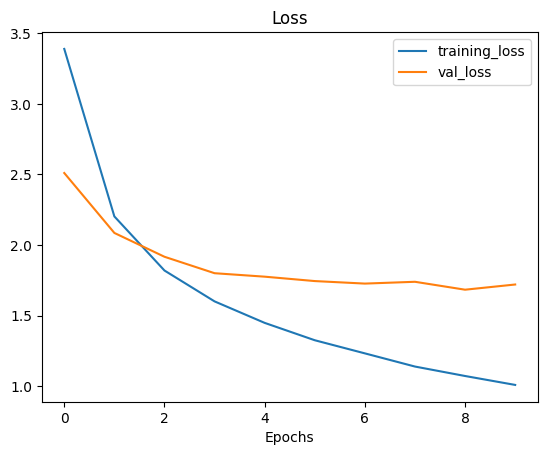

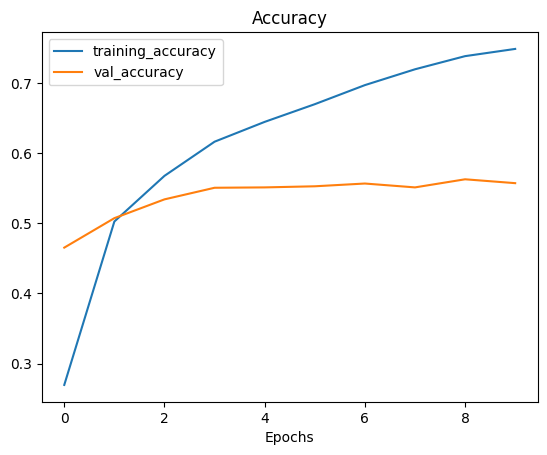

In [44]:
plot_loss_curves(history_mixed_precision_model)

In [45]:
model_2.evaluate(test_data)

790/790 [==============================] - 57s 72ms/step - loss: 1.5124 - accuracy: 0.5957


[1.5124435424804688, 0.5957227945327759]

* Does it make the model train faster?

  Yes, mixed-precision training make the model train faster. By using lower-precision data types (e.g., float16) for model weights and activations, it reduces memory requirements and computation time.

* Does it affect the accuracy or performance of our model?  

  Mixed-precision training slightly affected the model's accuracy. While it can speed up training, it may introduce numerical instability in some cases.

* What are the advantages of using mixed-precision training?

  The advantages of mixed-precision training include faster training times, reduced memory usage, and the ability to train larger and more complex models. It leverages specialized hardware support for lower-precision arithmetic, which can significantly accelerate deep learning tasks while maintaining good model performance.